<a href="https://colab.research.google.com/github/lyloc-logtech/ai-code/blob/main/faceid%2Bcamxuc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt

# Đường dẫn dữ liệu
data_dir = "/content/drive/MyDrive/TIA"
img_size = (160, 160)  # MobileNetV2 yêu cầu ảnh >= 160x160
batch_size = 16
seed = 42

# Load dữ liệu và chia train/val
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Cảm xúc:", class_names)

# Tối ưu pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Tăng cường dữ liệu
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Base model: MobileNetV2 (đã pre-trained)
base_model = MobileNetV2(input_shape=img_size + (3,),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False  # Freeze phần học sẵn

# Model đầy đủ
model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')  # Phân loại cảm xúc
])

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50
)

# Lưu model
model.save("emotion_mobilenet_model.h5")

Found 38 files belonging to 3 classes.
Using 31 files for training.
Found 38 files belonging to 3 classes.
Using 7 files for validation.
Cảm xúc: ['binhthuong', 'buon', 'vui']
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 7s/step - accuracy: 0.4032 - loss: 1.5011 - val_accuracy: 0.4286 - val_loss: 1.7104
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.3609 - loss: 1.2907 - val_accuracy: 0.2857 - val_loss: 1.6507
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 668ms/step - accuracy: 0.3622 - loss: 1.2640 - val_accuracy: 0.2857 - val_loss: 1.5373
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step - accuracy: 0.2547 - loss: 1.3686 - val_accuracy: 0.2857 - val_loss: 1.5850
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4261 - loss: 1.2847 - val_accuracy: 0.2857 - val_loss: 1.5721
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 602ms/step - accuracy: 0.4886 - loss: 1.1733 - val_accuracy: 0.4286 - val_loss: 1.6080
Epoch 7/50
2/2 ━━━━━━━━━━━━

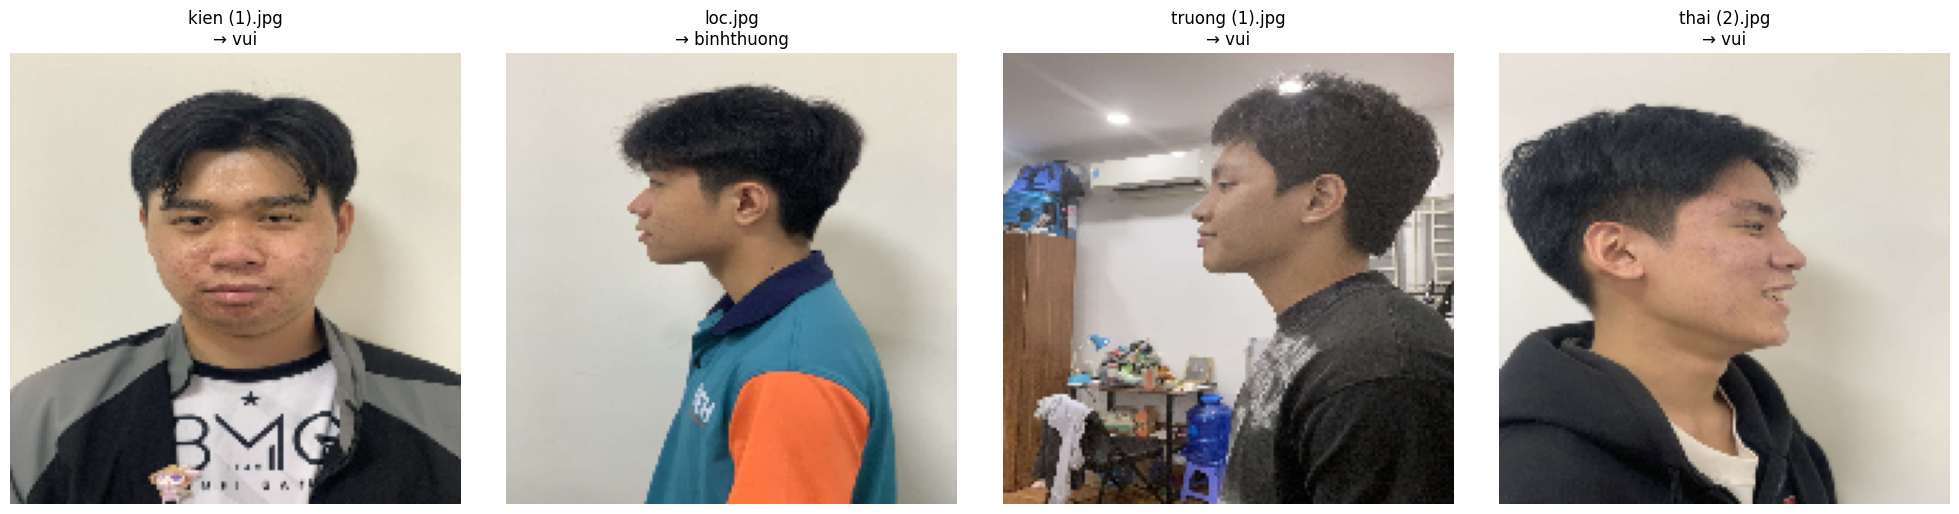

In [6]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

# Danh sách đường dẫn ảnh test
img_paths = [
    "/content/drive/MyDrive/TIA/binhthuong/kien binh thuong/kien (1).jpg",
    "/content/drive/MyDrive/TIA/binhthuong/locbinhthuong/loc.jpg",
    "/content/drive/MyDrive/TIA/vui/truongvui/truong (1).jpg",
    '/content/drive/MyDrive/TIA/vui/thaivui/thai (2).jpg',
]

# Vẽ nhiều ảnh trong 1 dòng
fig, axs = plt.subplots(1, len(img_paths), figsize=(5 * len(img_paths), 5))

for i, img_path in enumerate(img_paths):
    # Load và xử lý ảnh
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array_expanded = tf.expand_dims(img_array, 0)  # Thêm batch dimension

    # Dự đoán cảm xúc
    predictions = model.predict(img_array_expanded, verbose=0)
    predicted_class = class_names[np.argmax(predictions)]

    # Hiển thị ảnh và kết quả
    axs[i].imshow(np.array(img).astype("uint8"))
    axs[i].set_title(f"{os.path.basename(img_path)}\n→ {predicted_class}", fontsize=12)
    axs[i].axis("off")

plt.tight_layout()
plt.show()